In [1]:
!pip install stim~=1.14
!pip install numpy~=1.0  # 1.0 instead of 2.0 for pymatching compatibility later
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.5 MB/s eta 0:00:00a 0:00:010m


In [2]:
import stim
import numpy as np
import matplotlib.pyplot as plt
import pymatching
print(stim.__version__)

1.14.0


## Trying to create circuit from tableau based on stabilizer generators

In order to encode some codeword in the codespace, I've used this reference:
https://quantumcomputing.stackexchange.com/questions/32437/a-simple-way-of-encoding-qubit-in-stabilizer-codes-with-stim

In [168]:
def init_circuit():
    circuit = stim.Circuit()
    # Adding qubit coordinates metadata
    for qubit in range(16):
        x = qubit % 4
        y = qubit // 4
        circuit.append_operation("QUBIT_COORDS", [qubit], [x, y])
    print("Initialization complete.")
    return circuit

def encode(circuit):
    # Encoding step: Measuring X and Z stabilizers
    circuit += stim.Circuit("""
        # X-type stabilizers
        MPP X0*X1*X2*X3*X4*X5*X6*X7
        MPP X4*X5*X6*X7*X8*X9*X10*X11
        MPP X8*X9*X10*X11*X12*X13*X14*X15
        MPP X0*X1*X4*X5*X8*X9*X12*X13
        MPP X1*X2*X5*X6*X9*X10*X13*X14

        # Z-type stabilizers
        MPP Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7
        MPP Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11
        MPP Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15
        MPP Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13
        MPP Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14
    """)
    print("Encoding complete.")

def channel(circuit, error_rate, noisy_qubits=list(range(16))):
    # Noise channel: Adding X errors with probability 0 (for testing, can be adjusted)
    circuit.append("TICK")
    circuit.append("X_ERROR", noisy_qubits, error_rate)  # 10% error probability for demonstration
    circuit.append("TICK")
    print("Noise channel applied.")

def error_correction(circuit):
    # Error correction: Measuring the stabilizers again
    circuit += stim.Circuit("""
        # X-type stabilizers
        MPP X0*X1*X2*X3*X4*X5*X6*X7
        MPP X4*X5*X6*X7*X8*X9*X10*X11
        MPP X8*X9*X10*X11*X12*X13*X14*X15
        MPP X0*X1*X4*X5*X8*X9*X12*X13
        MPP X1*X2*X5*X6*X9*X10*X13*X14

        # Z-type stabilizers
        MPP Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7
        MPP Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11
        MPP Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15
        MPP Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13
        MPP Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14
    """)
    # TODO we extracted the syndromes but didn't correct errors.

    # Adding detectors for error syndrome extraction
    circuit += stim.Circuit("""
        DETECTOR rec[-10] rec[-20]
        DETECTOR rec[-9] rec[-19]
        DETECTOR rec[-8] rec[-18]
        DETECTOR rec[-7] rec[-17]
        DETECTOR rec[-6] rec[-16]
        DETECTOR rec[-5] rec[-15]
        DETECTOR rec[-4] rec[-14]
        DETECTOR rec[-3] rec[-13]
        DETECTOR rec[-2] rec[-12]
        DETECTOR rec[-1] rec[-11]
    """)

    circuit += stim.Circuit("""
        # Needed for error correction with pymatching. Trying this. see: https://quantumcomputing.stackexchange.com/questions/39001/how-does-observable-include-work
        # Note: this did produce an observable flips result. Not sure how well this works.
        # note2: started with one, which should be enough according to above link. However, even when having errors on multiple qubits we get good correction. only when applying on all of them (on or certain combinations) do we get many errors, but otherwise getting perfect results. so here we're trying to add all logical observables.
        MPP Z0*Z4*Z8*Z12
        OBSERVABLE_INCLUDE(0) rec[-1]
        MPP Z0*Z1*Z2*Z3
        OBSERVABLE_INCLUDE(1) rec[-1]
        MPP Z0*Z1*Z4*Z5
        OBSERVABLE_INCLUDE(2) rec[-1]
        MPP Z5*Z6*Z9*Z10
        OBSERVABLE_INCLUDE(3) rec[-1]
        MPP Z4*Z5*Z8*Z9
        OBSERVABLE_INCLUDE(4) rec[-1]
        MPP Z1*Z2*Z5*Z6
        OBSERVABLE_INCLUDE(5) rec[-1]
    """)
    print("Error correction complete.")

## Creating 1 circuit:

In [115]:

# Initialize the circuit
circuit = init_circuit()

# Encode the logical qubit
encode(circuit)

# Apply noise channel
channel(circuit, 0.5, [0])

# Perform error correction
error_correction(circuit)

# Print the final circuit for verification
print(circuit)

Initialization complete.
Encoding complete.
Noise channel applied.
Error correction complete.
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(0, 1) 4
QUBIT_COORDS(1, 1) 5
QUBIT_COORDS(2, 1) 6
QUBIT_COORDS(3, 1) 7
QUBIT_COORDS(0, 2) 8
QUBIT_COORDS(1, 2) 9
QUBIT_COORDS(2, 2) 10
QUBIT_COORDS(3, 2) 11
QUBIT_COORDS(0, 3) 12
QUBIT_COORDS(1, 3) 13
QUBIT_COORDS(2, 3) 14
QUBIT_COORDS(3, 3) 15
MPP X0*X1*X2*X3*X4*X5*X6*X7 X4*X5*X6*X7*X8*X9*X10*X11 X8*X9*X10*X11*X12*X13*X14*X15 X0*X1*X4*X5*X8*X9*X12*X13 X1*X2*X5*X6*X9*X10*X13*X14 Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7 Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11 Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15 Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13 Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14
TICK
X_ERROR(0.5) 0
TICK
MPP X0*X1*X2*X3*X4*X5*X6*X7 X4*X5*X6*X7*X8*X9*X10*X11 X8*X9*X10*X11*X12*X13*X14*X15 X0*X1*X4*X5*X8*X9*X12*X13 X1*X2*X5*X6*X9*X10*X13*X14 Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7 Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11 Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15 Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13 Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14

## plot multiple runs with different error rates

Initialization complete.
Encoding complete.
Running simulation for error rate: 0.00
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.01
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.03
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.04
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.06
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.07
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.09
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.10
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.12
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.14
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.15
Noise channel ap

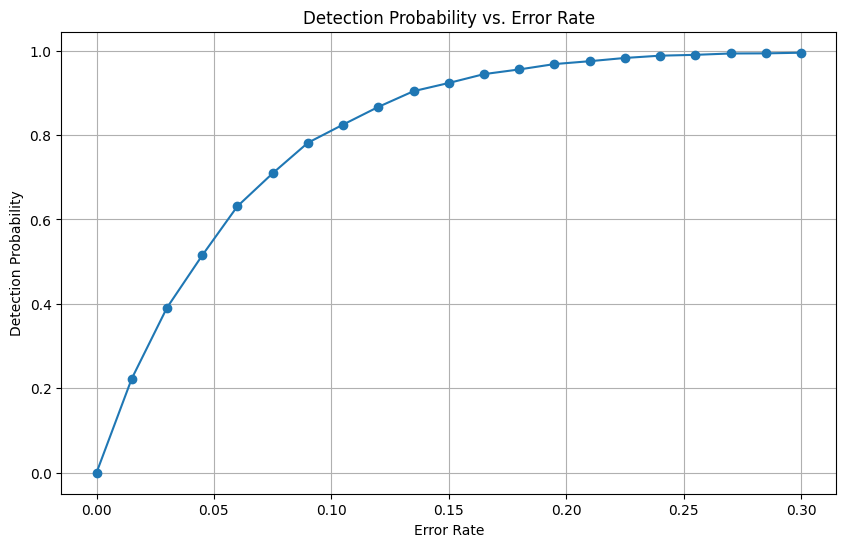

In [100]:
def run_simulation(circuit, error_rate, shots=10000):
    # Apply noise channel with the specified error rate
    channel(circuit, error_rate)

    # Perform error correction
    error_correction(circuit)

    # Compile the circuit and run the simulation
    sampler = circuit.compile_detector_sampler()
    samples = sampler.sample(shots=shots)

    # Calculate the detection probability (fraction of shots with any detection event)
    detection_events = np.any(samples, axis=1)
    detection_probability = np.mean(detection_events)

    return detection_probability

def plot_detection_probability(error_rates, detection_probabilities):
    plt.figure(figsize=(10, 6))
    plt.plot(error_rates, detection_probabilities, marker='o', linestyle='-')
    plt.xlabel("Error Rate")
    plt.ylabel("Detection Probability")
    plt.title("Detection Probability vs. Error Rate")
    plt.grid(True)
    plt.show()

# Initialize the circuit
circuit = init_circuit()

# Encode the logical qubit
encode(circuit)

# Define a range of error rates to test
error_rates = np.linspace(0, 0.3, 21)  # From 0 to 0.2 in steps of 0.01
detection_probabilities = []

# Run the simulation for each error rate
for error_rate in error_rates:
    print(f"Running simulation for error rate: {error_rate:.2f}")
    detection_probability = run_simulation(circuit.copy(), error_rate)
    detection_probabilities.append(detection_probability)

# Plot the results
plot_detection_probability(error_rates, detection_probabilities)

## Plot multiple runs with different error rates - fidelity
(probably not correct, was done with help of GPT)

In [63]:
def calculate_fidelity(circuit, error_rate, shots=10000):
    # Apply noise channel and error correction
    channel(circuit, error_rate)
    error_correction(circuit)

    # TODO not sure if this is correct. we don't decode here so how do we know if we have a logical 0? also
    # Logical measurement in the Z basis (ideal state is |0>_L)
    circuit.append("M", list(range(16)))
    sampler = circuit.compile_sampler()
    samples = sampler.sample(shots=shots)

    # Count the fraction of samples where the logical state is measured as |0>_L
    logical_measurements = np.sum(samples, axis=1) % 2  # Parity check
    fidelity = np.mean(logical_measurements == 0)  # Fraction of times we get logical |0>
    return fidelity

def plot_fidelity(error_rates, fidelities):
    plt.figure(figsize=(10, 6))
    plt.plot(error_rates, fidelities, marker='o', linestyle='-')
    plt.xlabel("Error Rate")
    plt.ylabel("Fidelity")
    plt.title("Fidelity vs. Error Rate")
    plt.grid(True)
    plt.show()

# Initialize the circuit
circuit = init_circuit()
encode(circuit)

# Define a range of error rates to test
error_rates = np.linspace(0, 0.2, 21)
fidelities = []

# Run fidelity calculations for each error rate
for error_rate in error_rates:
    print(f"Calculating fidelity for error rate: {error_rate:.2f}")
    fidelity = calculate_fidelity(circuit.copy(), error_rate)
    fidelities.append(fidelity)

# Plot the fidelity results
plot_fidelity(error_rates, fidelities)

Initialization complete.
Encoding complete.
Calculating fidelity for error rate: 0.00
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.01
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.02
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.03
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.04
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.05
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.06
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.07
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.08
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.09
Noise channel applied.
Error correction complete.


KeyboardInterrupt: 

In [48]:
circuit.to_crumble_url()

'https://algassert.com/crumble#circuit=Q(0,0)0;Q(1,0)1;Q(2,0)2;Q(3,0)3;Q(0,1)4;Q(1,1)5;Q(2,1)6;Q(3,1)7;Q(0,2)8;Q(1,2)9;Q(2,2)10;Q(3,2)11;Q(0,3)12;Q(1,3)13;Q(2,3)14;Q(3,3)15;MPP_X0*X1*X2*X3*X4*X5*X6*X7_X4*X5*X6*X7*X8*X9*X10*X11_X8*X9*X10*X11*X12*X13*X14*X15_X0*X1*X4*X5*X8*X9*X12*X13_X1*X2*X5*X6*X9*X10*X13*X14_Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7_Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11_Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15_Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13_Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14;TICK;X_ERROR(0.1)0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15;TICK;MPP_X0*X1*X2*X3*X4*X5*X6*X7_X4*X5*X6*X7*X8*X9*X10*X11_X8*X9*X10*X11*X12*X13*X14*X15_X0*X1*X4*X5*X8*X9*X12*X13_X1*X2*X5*X6*X9*X10*X13*X14_Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7_Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11_Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15_Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13_Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14;DT_rec[-10]_rec[-20];DT_rec[-9]_rec[-19];DT_rec[-8]_rec[-18];DT_rec[-7]_rec[-17];DT_rec[-6]_rec[-16];DT_rec[-5]_rec[-15];DT_rec[-4]_rec[-14];DT_rec[-3]_rec[-13];DT_rec[-2]_rec[-12];DT_rec[-1]_rec[-11]'

In [9]:
sampler = circuit.compile_sampler()
sampler.sample(shots=10)

array([[ True, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False,  True, False, False,
         True,  True],
       [False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False,  True, False,  True,  True,
         True, False],
       [False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
         True, False],
       [ True, False, False,  True, False, False, False, False, False,
        False,  True, False, False,  True, False, False, False, False,
         True, False],
       [False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False,  True, False,  True,  True,
        False,  True],
       [False,  True, False, False,  True, False, False, False, False,
        False, False,  True, False, False,  True, False,  True, False,
         True, False],
       [Fa

In [17]:
sampler = circuit.compile_detector_sampler()
sampler.sample(shots=5)

array([[False, False, False, False, False,  True, False,  True,  True,
        False],
       [False, False, False, False, False, False, False,  True, False,
        False],
       [False, False, False, False, False, False,  True,  True,  True,
         True],
       [False, False, False, False, False, False,  True, False,  True,
         True],
       [False, False, False, False, False, False, False, False,  True,
         True]])

## Error correction with pymatching
Attempt at actually doing the error correction using pymatching
currently not working

In [199]:
# Creating another circuit (Can delete this - duplicate. this is just for easier work)
# Initialize the circuit
circuit = init_circuit()

# Encode the logical qubit
encode(circuit)

# Apply noise channel
channel(circuit, 0.5, [6,7,11,12])

# Perform error correction
error_correction(circuit)

# Print the final circuit for verification
print(circuit)

Initialization complete.
Encoding complete.
Noise channel applied.
Error correction complete.
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(0, 1) 4
QUBIT_COORDS(1, 1) 5
QUBIT_COORDS(2, 1) 6
QUBIT_COORDS(3, 1) 7
QUBIT_COORDS(0, 2) 8
QUBIT_COORDS(1, 2) 9
QUBIT_COORDS(2, 2) 10
QUBIT_COORDS(3, 2) 11
QUBIT_COORDS(0, 3) 12
QUBIT_COORDS(1, 3) 13
QUBIT_COORDS(2, 3) 14
QUBIT_COORDS(3, 3) 15
MPP X0*X1*X2*X3*X4*X5*X6*X7 X4*X5*X6*X7*X8*X9*X10*X11 X8*X9*X10*X11*X12*X13*X14*X15 X0*X1*X4*X5*X8*X9*X12*X13 X1*X2*X5*X6*X9*X10*X13*X14 Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7 Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11 Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15 Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13 Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14
TICK
X_ERROR(0.5) 6 7 11 12
TICK
MPP X0*X1*X2*X3*X4*X5*X6*X7 X4*X5*X6*X7*X8*X9*X10*X11 X8*X9*X10*X11*X12*X13*X14*X15 X0*X1*X4*X5*X8*X9*X12*X13 X1*X2*X5*X6*X9*X10*X13*X14 Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7 Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11 Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15 Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13 Z1*Z2*Z5*Z6*Z9*Z10

In [200]:
# Counting errors using pymatching to create a decoder
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 0 wrong predictions (logical errors) out of 100000 shots


In [26]:
dem = circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.4) D5
    error(0.4) D5 D6
    error(0.4) D5 D6 D8
    error(0.4) D5 D6 D8 D9 L0
    error(0.4) D5 D6 D9 L0
    error(0.4) D5 D8
    error(0.4) D5 D8 D9 L0
    error(0.4) D5 D9 L0
    error(0.4) D6 D7
    error(0.4) D6 D7 D8
    error(0.4) D6 D7 D8 D9 L0
    error(0.4) D6 D7 D9 L0
    error(0.4) D7
    error(0.4) D7 D8
    error(0.4) D7 D8 D9 L0
    error(0.4) D7 D9 L0
    detector D0
    detector D1
    detector D2
    detector D3
    detector D4
''')
